# Purpose

To recover the story triggers that were lost by mistake due to an error in stimulus script

In [1]:
import pyxdf    # 1.17.0'
import pandas as pd    # 2.2.3
import numpy as np    #  2.26
import matplotlib.pyplot as plt    #3.10.1
from glob import glob
import librosa    # 0.11.0
from tqdm import tqdm
import sounddevice as sd    #0.5.2



subject = 'P5943825'
xdf_path = f'/Users/bryan.gonzalez/CUNY_subs/sub-{subject}/sub-{subject}_ses-S001_task-CUNY_run-002_mobi.xdf'

In [2]:
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]
print(f"Streams collected: {streams_collected}")

Streams collected: ['EGI NetAmp 0', 'OpenSignals', 'OpenSignals', 'Stimuli_Markers', 'WebcamStream', 'Tobii', 'Microphone']


In [14]:
stim_idx = streams_collected.index('Stimuli_Markers')
stim_df = pd.DataFrame(data[stim_idx]['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = data[stim_idx]['time_stamps']
stim_df['time'] = (data[stim_idx]['time_stamps'] - data[stim_idx]['time_stamps'][0])

# Load mic stream

In [4]:
mic_idx = streams_collected.index('Microphone')
mic_df = pd.DataFrame(data[mic_idx]['time_series'])
mic_df.rename(columns={0: 'int'}, inplace=True)
mic_df['lsl_time_stamp'] = data[mic_idx]['time_stamps']
mic_df['time'] = (data[mic_idx]['time_stamps'] - data[5]['time_stamps'][0]) # time in seconds from 0

# Reduce the mic_data to only the story listening events, we have triggers for onset and offset of the story listening block
event = 'StoryListening' 
mic_df = mic_df.loc[(mic_df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (mic_df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

#mic_df.head(100)

Identify mic amplitude above threshold

In [5]:
rate = 44100
chunk_size = 4410
threshold = 75

audio = mic_df['int'].values.astype(np.int16)
#num_chunks = len(audio) // chunk_size
n_samples= len(audio)
is_audio = np.zeros(n_samples, dtype=bool)
energies = []


for start in tqdm(range(0, n_samples, chunk_size)):
    end = min(start + chunk_size, n_samples)
    chunk = audio[start:end]
    energy = np.mean(np.abs(chunk))
    if energy > threshold:
        is_audio[start:end] = True


    energies.append(energy)

mic_df['mic_signal'] = is_audio

energies = np.array(energies)



100%|██████████| 11885/11885 [00:00<00:00, 88633.12it/s]


# Look for the Silences

Because the blocks where 'is_audio' == True are sparse due to high sampling rate (i.e. pauses between words)

In [6]:
# Make sure 'is_audio' is a boolean Series (or 0/1 integers)
is_audio = mic_df['mic_signal'].astype(bool)

# Identify where values change (True <-> False)
change_points = is_audio.ne(is_audio.shift()).cumsum()

# Group by these change points and get lengths
runs = mic_df.groupby(change_points).agg({
    'mic_signal': ['first', 'size'],
    'time': ['first', 'last']
})
runs.columns = ['value', 'length', 'start_time', 'end_time']
runs = runs.reset_index(drop=True)

# Select runs where value == False and length > 132300
long_false_blocks = runs[(runs['value'] == False) & (runs['length'] > 132300)]   # silences much be longer than 132300 rows (44100 Hz x 3 seconds = 132300)

print(long_false_blocks)


# Initialize column with False
mic_df['long_silence'] = False

# Mark rows that fall into those long silence blocks
for _, row in long_false_blocks.iterrows():
    mic_df.loc[(mic_df['time'] >= row['start_time']) & (mic_df['time'] <= row['end_time']), 'long_silence'] = True

mic_df['is_audio'] = ~mic_df['long_silence']  # Invert long_silence to get is_audio


      value   length   start_time     end_time
2     False   855540   334.127912   353.528194
236   False   207270   476.930154   481.630205
246   False   211680   483.330254   488.130307
262   False  1666980   495.230441   533.031012
264   False   277830   533.131036   539.431112
266   False   568890   539.631138   552.531318
826   False   149940   714.233878   717.633909
834   False  1821330   720.433975   761.734601
840   False   136710   764.134661   767.234687
842   False   308700   767.434713   774.434800
1148  False  2178540   911.536975   960.937727
1152  False   251370   961.337756   967.037823
1404  False  2112390  1063.239356  1111.140085
1814  False  1314180  1263.242495  1293.042940
1816  False   520380  1293.342967  1305.143130
2252  False   864360  1466.745689  1486.345974
2254  False  1585390  1486.445998  1522.396426


# Sanity Check

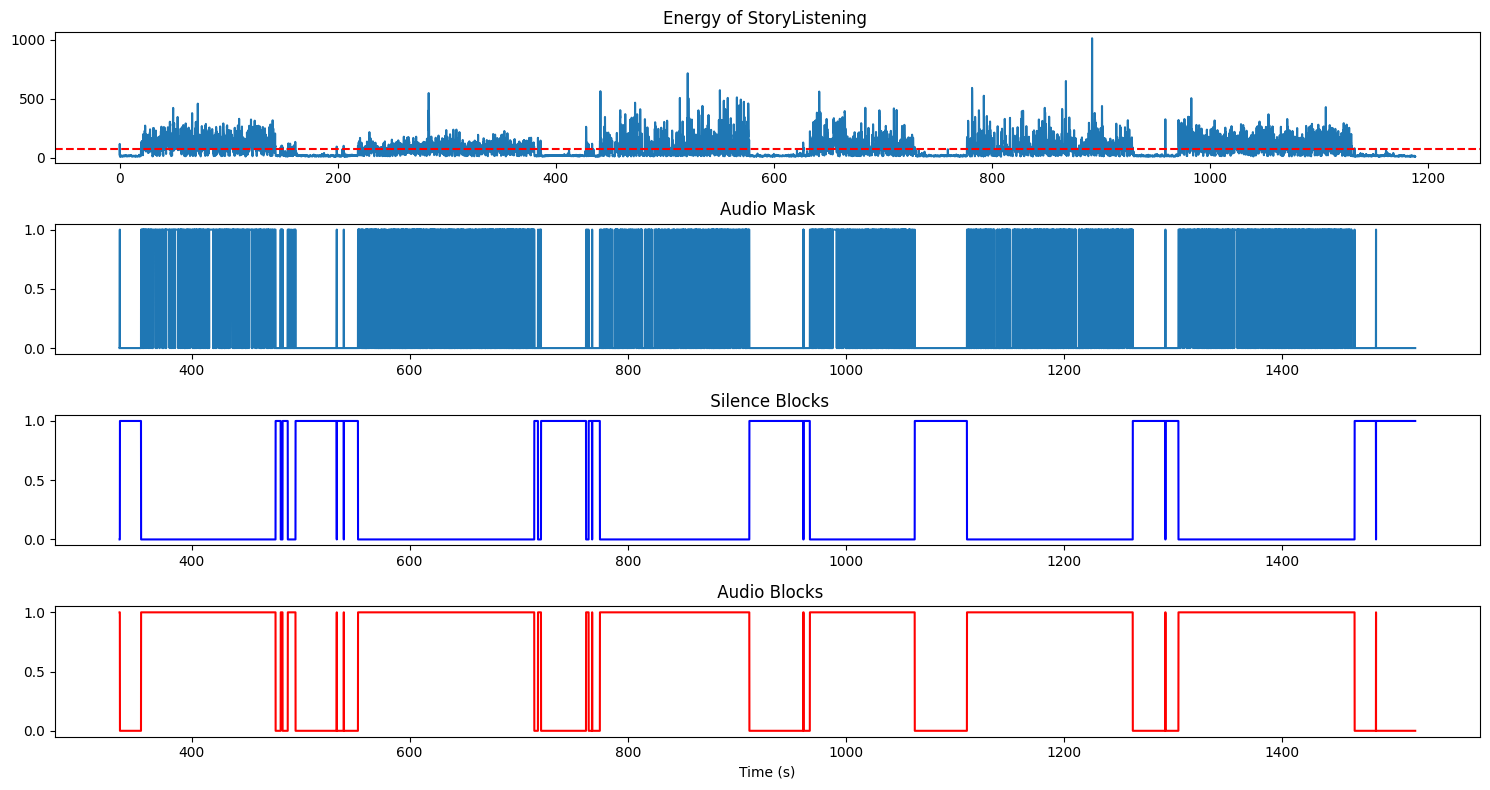

In [17]:

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=False, figsize=(15, 8))
ax[0].plot(np.arange(len(energies)) * chunk_size / rate, energies)
ax[0].axhline(y=threshold, color='r', linestyle='--', label='Threshold')
ax[0].set_title(f'Energy of {event} ')

ax[1].plot(mic_df['time'], mic_df['mic_signal'])
ax[1].set_title(f'Audio Mask')



ax[2].plot(mic_df['time'], mic_df['long_silence'], color='b')
ax[2].set_title(' Silence Blocks')
ax[3].plot(mic_df['time'], mic_df['is_audio'], color='r')
ax[3].set_title(' Audio Blocks')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.savefig('trigger_recovery_sanity check.png', dpi=300)
plt.show()


## Label each audio segment with a number

In [8]:

# Example box function
s = mic_df['is_audio'].astype(int)  # Convert boolean to int (0s and 1s)
# Treat 1s (or True) as boxes
is_box = s.astype(bool)

# Find the start of each new box (True preceded by False)
box_start = is_box & ~is_box.shift(fill_value=False)

# Use cumsum to increment on each new box start
box_ids = box_start.cumsum()

# Mask: assign box ID where s == 1, else 0
labeled_boxes = box_ids.where(is_box, 0)
mic_df['audio_segment'] = labeled_boxes

### get the story order from psychopy file
### assign the audio segment as noise or the next story in the order if the segment is greater in duration than 93 seconds (shortest story)


In [9]:

psycho = pd.read_csv(f'/Users/bryan.gonzalez/CUNY_subs/sub-{subject}/sub-{subject}_task-CUNY_run-001_behavior.csv', sep=',', header=0)
audio_order = [f.split('/')[-1].split('.')[0] for f in psycho.AudioFile.unique() if pd.notna(f)]

story_count = 0
# get the duration in seconds of each audio segment
mic_df['sound_id'] = 'silence'
for i in range(1, mic_df['audio_segment'].max() + 1):
    segment = mic_df[mic_df['audio_segment'] == i]
    duration = (segment['time'].max() - segment['time'].min())
    if duration < 93:
        mic_df.loc[mic_df['audio_segment'] == i, 'sound_id'] = 'noise' 
    else:
        mic_df.loc[mic_df['audio_segment'] == i, 'sound_id'] = audio_order[story_count]
        story_count += 1

    print(f"Audio Segment {i}: Duration = {duration:.2f} seconds")

Audio Segment 1: Duration = 0.20 seconds
Audio Segment 2: Duration = 123.40 seconds
Audio Segment 3: Duration = 1.70 seconds
Audio Segment 4: Duration = 7.10 seconds
Audio Segment 5: Duration = 0.10 seconds
Audio Segment 6: Duration = 0.20 seconds
Audio Segment 7: Duration = 161.70 seconds
Audio Segment 8: Duration = 2.80 seconds
Audio Segment 9: Duration = 2.40 seconds
Audio Segment 10: Duration = 0.20 seconds
Audio Segment 11: Duration = 137.10 seconds
Audio Segment 12: Duration = 0.40 seconds
Audio Segment 13: Duration = 96.20 seconds
Audio Segment 14: Duration = 152.10 seconds
Audio Segment 15: Duration = 0.30 seconds
Audio Segment 16: Duration = 161.60 seconds
Audio Segment 17: Duration = 0.10 seconds


In [10]:
mic_df.sound_id.unique()

array(['noise', 'silence', 'Frog_Dissection_Disaster',
       'Left_Home_Alone_in_a_Tornado',
       'I_Decided_To_Be_Myself_And_Won_A_Dance_Contest',
       'I_Fully_Embarrassed_Myself_In_Zoom_Class1', 'Camp_Lose_A_Friend',
       'The_Birthday_Party_Prank'], dtype=object)

# Sanity Check: Listening...

In [ ]:

story = mic_df.loc[mic_df['sound_id'] == 'I_Decided_To_Be_Myself_And_Won_A_Dance_Contest', 'int'].values.astype(np.int16)
sd.play(story, samplerate=44100)

# Placing the onset/offsets in the stim_df

In [11]:
audio_order

['Frog_Dissection_Disaster',
 'Left_Home_Alone_in_a_Tornado',
 'I_Decided_To_Be_Myself_And_Won_A_Dance_Contest',
 'I_Fully_Embarrassed_Myself_In_Zoom_Class1',
 'Camp_Lose_A_Friend',
 'The_Birthday_Party_Prank']

In [15]:
for story in audio_order:
    story_df = mic_df[mic_df['sound_id'] == story]
    story_onset = mic_df.loc[mic_df['sound_id'] == story, 'time'].min()
    story_offset = mic_df.loc[mic_df['sound_id'] == story, 'time'].max()


    if story == 'Camp_Lose_A_Friend':
        event_id = 20
    elif story == 'Frog_Dissection_Disaster':
        event_id = 30
    elif story == 'I_Decided_To_Be_Myself_And_Won_A_Dance_Contest':
        event_id = 40
    elif story == 'I_Fully_Embarrassed_Myself_In_Zoom_Class1':
        event_id = 50
    elif story == 'Left_Home_Alone_in_a_Tornado':
        event_id = 60
    elif story == 'The_Birthday_Party_Prank':
        event_id = 70


    # Add the story onset and offset to the stim_df
    row = [event_id, f'{events[event_id]}', story_df.lsl_time_stamp.min(), story_df.time.min()]
    # Append the row to stim_df
    stim_df.loc[len(stim_df)] = row
    row = [event_id + 1, f'{events[event_id+1]}', story_df.lsl_time_stamp.max(), story_df.time.max()]
    # Append the row to stim_df
    stim_df.loc[len(stim_df)] = row

In [16]:
#sort by the lsl_time_stamp
stim_df.sort_values('lsl_time_stamp')

,trigger,event,lsl_time_stamp,time
0,2.000000e+02,Onset_Experiment,12249.952149,0.000000
1,1.744057e+09,psychopy_time_stamp,12249.952161,0.000012
2,1.000000e+01,Onset_RestingState,12260.380544,10.428395
3,1.744057e+09,psychopy_time_stamp,12260.380554,10.428405
4,1.100000e+01,Offset_RestingState,12560.378175,310.426026
...,...,...,...,...
230,1.744059e+09,psychopy_time_stamp,14290.831409,2040.879260
231,8.100000e+01,Offset_SocialTask,14591.371014,2341.418864
232,1.744060e+09,psychopy_time_stamp,14591.371027,2341.418877
233,2.010000e+02,Offset_Experiment,14596.362209,2346.410059
